In [5]:
# @Start date : 2023/1/5

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.style.use('default')
import sympy as sp
from scipy.optimize import fsolve
import sys
sys.path.append("..")
class Lyapunov_Worm_multi_D:
    def __init__(self, dim: int = 2, varargin=None):
        self.dim = dim
        self.step = 400
        self.rs = np.ones(dim) * 0.5
        self.w = np.ones(dim) * 4.
        self.k = 8. * np.ones(dim)
        self.n = 1.0 * np.ones(dim)
        self.bi = np.ones(dim) * 5.
        self.neuro_state = np.array(
            (-self.w * self.sig(np.zeros_like(self.n)) + self.bi) / self.rs)
        self.nsf = 0.2
        self.dt = 0.5
        self.weights_in = np.ones(dim) * 1
        self.neural_history = []
        self.neural_history.append(self.neuro_state)
        self.tau = np.ones(dim)
        self.neuron_sensory_history = []
        if varargin:
            for key, value in varargin.items():
                setattr(self, key, value)

    def decide(self, history, save_history=False, init=False):
        self.neuron_sensory_history = history
        if init:
            neuro_state = np.array((-self.w * self.sig(np.zeros_like(self.n)) + self.bi) / self.rs)
            # neuro_state = np.array([2.,2.,2.,10.])
        else:
            neuro_state = self.neuro_state.copy()
        offset = np.mean(np.mean(history, axis=-1))

        for _ in range(self.step):
            sensory_in = self.history_sample(history, offset)
            neural_input = sensory_in * self.weights_in
            noise = self.nsf * np.random.normal(0, 1, self.dim)
            dxs, nxs = self.bmfun(neural_inputs=neural_input, neural_state=neuro_state)
            neuro_state += (dxs + noise) * self.dt
            neuro_state[neuro_state < 0] = 0.
            if save_history:
                self.neural_history.append(neuro_state.copy())
        self.last_act = np.argmax(neuro_state)
        self.neuro_state = neuro_state.copy()
        return np.argmax(neuro_state)

    def decide_simulation(self, r1_mean, r2_mean, r1_std, r2_std, save_history=False, init=False):
        self.neuron_sensory_history = [r1_mean, r2_mean]
        offset = (r1_mean + r2_mean) / 2
        if init:
            neuro_state = np.array((-self.w * self.sig(np.zeros_like(self.n)) + self.bi) / self.rs)
        else:
            neuro_state = self.neural_history[-1].copy()
        for _ in tqdm(range(self.step)):

            all_effects = np.sum(self.w * self.sig(neuro_state))
            I_mean = np.array([r1_mean-offset, r2_mean-offset])
            I_std = np.array([r1_std, r2_std])
            neuro_state += (self.rs * (-neuro_state)+(-(all_effects - self.w * self.sig(neuro_state)) +
                                                      self.bi + I_mean))*self.dt + np.sqrt(self.dt)*np.random.normal(0,1,self.dim)*np.sqrt(self.nsf**2+I_std**2)
            neuro_state[neuro_state < 0] = 0.
            if save_history:
                self.neural_history.append(neuro_state.copy())

        self.last_act = np.argmax(neuro_state)
        self.neuro_state = neuro_state.copy()
        return np.argmax(neuro_state)

    def theory_calculation(self,r1_mean, r2_mean, r1_std, r2_std ):

        if self.dim > 2:
            print('dim > 2')
            return

        def sig(x, n, k):
            return 1 / (1 + np.exp(n * (k - x)))
        def func(x, gamma, w, I, b, n, k):
            return [-gamma[0] * x[0] - sig(x[1], n[0], k[0]) * w[0] + I[0] + b[0],
                    -gamma[1] * x[1] - sig(x[0], n[1], k[1]) * w[1] + I[1] + b[1]]
        sigma = np.array([r1_std**2+self.nsf**2, r2_std**2+self.nsf**2])
        gamma = self.rs
        w = self.w
        I = [r1_mean, r2_mean]  # input
        b = self.bi
        n = self.n
        k = self.k
        x, y = sp.symbols('x y')
        # compute local minimum and saddle point
        root1 = fsolve(func, x0=np.array([20, 0]), args=(gamma, w, I, b, n, k))
        root2 = fsolve(func, x0=np.array([0, 20]), args=(gamma, w, I, b, n, k))
        root3 = fsolve(func, x0=np.array([7, 7]), args=(gamma, w, I, b, n, k))
        print(root1)
        print(root2)
        print(root3)
        # Hopfield energy
        sx = sp.exp(n[0] * k[0]) + sp.exp(n[0] * x)
        sy = sp.exp(n[1] * k[1]) + sp.exp(n[1] * y)
        f1 = gamma[0] * (x * sp.exp(n[0] * x) / sx - sp.log(sx) / n[0]) + gamma[1] * (
                    y * sp.exp(n[1] * y) / sy - sp.log(sy) / n[1])
        f2 = -(I[0] + b[0]) * sp.exp(n[0] * x) / sx - (I[1] + b[1]) * sp.exp(n[1] * y) / sy
        f3 = 0.5 * (w[0] + w[1]) * (sp.exp(n[0] * x) / sx) * (sp.exp(n[1] * y) / sy)
        f = f1 + f2 + f3

        # energy of local minimum and saddle point
        Energy_saddle = f.subs([(x, root3[0]), (y, root3[1])])
        Energy_min_x = f.subs([(x, root1[0]), (y, root1[1])])
        Energy_min_y = f.subs([(x, root2[0]), (y, root2[1])])

        # compute the derivative and curvature
        fx = sp.diff(f, x)
        fxx = sp.diff(fx, x)
        fxy = sp.diff(fx, y)
        fy = sp.diff(f, y)
        fyx = sp.diff(fy, x)
        fyy = sp.diff(fy, y)

        # Trace of H*Sigma
        Tr_HN = fxx * sigma[0] + fyy * sigma[1]
        # Trace of H
        Tr_H = fxx + fyy

        d_E1 = Energy_saddle - Energy_min_x
        d_E2 = Energy_saddle - Energy_min_y
        # H = np.matrix([[fxx, fxy],[fyx, fyy]])
        Tr_HN_x = Tr_HN.subs([(x, root1[0]), (y, root1[1])])
        Tr_HN_y = Tr_HN.subs([(x, root2[0]), (y, root2[1])])

        Tr_H_x = Tr_H.subs([(x, root1[0]), (y, root1[1])])
        Tr_H_y = Tr_H.subs([(x, root2[0]), (y, root2[1])])

        p1 = 1 / (1 + np.exp(float(-(d_E1 / Tr_HN_x - d_E2 / Tr_HN_y) * Tr_H_x * 2)))
        p2 = 1 / (1 + np.exp(float(-(d_E2 / Tr_HN_y - d_E1 / Tr_HN_x) * Tr_H_y * 2)))

        return p1


    def sig(self, x):

        return 1. / (1 + np.exp(-self.n[0] * (x - self.k[0])))

    def bmfun(self, neural_inputs, neural_state, dim=2):  # 得到一个time step的dx

        if len(neural_state.shape) >= dim:
            big_dxs = np.zeros_like(neural_state)
            big_nxs = np.zeros_like(neural_state)

            for i, y in enumerate(neural_state.T):
                if len(y.shape) >= dim:
                    for j, z in enumerate(y):
                        big_dxs[:, j, i], big_nxs[:, j, i] = self.bmfun(neural_inputs, z)
                else:
                    big_dxs[:, i], big_nxs[:, i] = self.bmfun(neural_inputs, y)
        else:  # 在game中仅用到了一维的， 高维的是用来画model speed判断每一个点的速度的。
            all_effects = np.sum(self.w * self.sig(neural_state))
            big_nxs = (-(all_effects - self.w * self.sig(neural_state)) + self.bi + neural_inputs) / self.rs

            big_dxs = (1 / self.tau) * self.rs * (-neural_state + big_nxs)
        return big_dxs, big_nxs

    def history_sample(self, history, offset):
        if history.shape[0] != self.dim:
            print('WRONG INPUT')
            return
        sensory_list = []

        for i in range(self.dim):
            r = np.random.choice(history[i])
            sensory_list.append(r)
        # offset = np.mean(sensory_list)
        sensory = np.array(sensory_list) - offset
        return sensory

    def potfun(self, x1, x2):

        # parse params
        r1 = self.rs[0]
        r2 = self.rs[1]
        k1 = self.k[0]
        k2 = self.k[1]
        n1 = self.n[0]
        n2 = self.n[1]
        w21 = self.w[0]
        w12 = self.w[1]
        if self.neuron_sensory_history != []:
            input_1 = self.neuron_sensory_history[0]
            input_2 = self.neuron_sensory_history[1]
            I1 = self.bi[0] + np.mean(input_1)
            I2 = self.bi[1] + np.mean(input_2)
        elif self.neuron_sensory_history == []:
            I1 = self.bi[0]
            I2 = self.bi[1]

        # I1 = self.bi[0]
        # I2 = self.bi[1]

        e1 = r1 * ((np.exp(n1 * x1) * x1 / (np.exp(n1 * k1) + np.exp(n1 * x1))) - np.log(
            (np.exp(n1 * k1) + np.exp(n1 * x1))) / n1) + r2 * (
                     (np.exp(n2 * x2) * x2 / (np.exp(n2 * k2) + np.exp(n2 * x2))) - np.log(
                 (np.exp(n2 * k2) + np.exp(n2 * x2))) / n2)
        e2 = -I1 * (np.exp(n1 * x1) / (np.exp(n1 * x1) + np.exp(n1 * k1))) - I2 * (
                np.exp(n2 * x2) / (np.exp(n2 * x2) + np.exp(n2 * k2)))
        e3 = 1 / 2 * (w12 + w21) * (np.exp(n1 * x1) / (np.exp(n1 * x1) + np.exp(n1 * k1))) * (
                np.exp(n2 * x2) / (np.exp(n2 * x2) + np.exp(n2 * k2)))

        pot = e1 + e2 + e3
        return pot, e1, e2, e3

    def nullcfun_bmc(self, xr1, xr2, inc, ninp,
                     getDict=False):
        x1 = np.arange(xr1[0], xr1[1] + 1, inc[0])
        x2 = np.arange(xr2[0], xr2[1] + 1, inc[1])

        ux1, ux2 = np.meshgrid(x1, x2)
        xo_dxs, xo_nxs = self.bmfun(neural_inputs=ninp, neural_state=np.array([x1, x2]))
        uo_dxs, uo_nxs = self.bmfun(neural_inputs=ninp, neural_state=np.array([ux1, ux2]))
        up = np.zeros(uo_dxs.shape[1:])
        for i, x in enumerate(uo_dxs.T):
            for j, y in enumerate(x):
                up[j, i] = np.sqrt(y @ y.T)

        if getDict:
            nco = {'x': x1, 'y': x2, 'nxs': xo_nxs[0, :], 'nys': xo_nxs[1, :]}
            uo = {'x': ux1, 'y': ux2, 'ux': uo_dxs[0, :, :], 'uy': uo_dxs[1, :, :], 'sp': up}
            return nco, uo
        else:
            return up, uo_dxs, ux1, ux2, x1, x2, xo_nxs

    def plot_energy(self):
        if self.dim != 2:
            print("energy can be plotted only in 2D")
        else:
            
            neural_history_copy = np.array(self.neural_history)
            xr1 = np.array([0, 20])
            xr2 = np.array([0, 20])
            inc = np.array([.05, .05])
            # nco, uo = self.nullcfun_bmc(xr1, xr2, inc, nmin*np.ones(2), getDict=True)
            input_1 = np.array(self.neuron_sensory_history)[0] if len(self.neuron_sensory_history) != 0 else 0
            input_2 = np.array(self.neuron_sensory_history)[1] if len(self.neuron_sensory_history) != 0 else 0
            nco, uo = self.nullcfun_bmc(xr1, xr2, inc, np.array([np.mean(input_1), np.mean(input_2)]), getDict=True)
            
            # fig, ax = plt.subplots()
            fig, ax = plt.subplots()
            # plt.pcolormesh(uo['x'], uo['y'], uo['sp'], cmap='jet', shading='nearest')
            pot, e1, e2, e3 = self.potfun(uo['x'], uo['y'])
            plt.pcolormesh(nco['x'], nco['y'], pot, cmap='viridis', shading='auto')
            cb = plt.colorbar()
            cb.ax.tick_params(labelsize=20)
            plt.plot(nco['nxs'], nco['y'], 'r')
            plt.plot(nco['x'], nco['nys'], 'g')
            plt.scatter(neural_history_copy[0:5000:2, 0], neural_history_copy[0:5000:2, 1], color='w', s=1.3)
            ax.set_xlim(xr1[0], xr1[1])
            ax.set_ylim(xr2[0], xr2[1])
            # plotstandard
            plt.xlabel('X', fontsize=20)
            plt.ylabel('Y', fontsize=20)
            plt.xlim(0,20)
            plt.ylim(0,20)
            plt.tick_params(axis='both',which='major',labelsize=20)
            plt.show()

    def plot_distribution(self):

        neural_history_copy = np.array(self.neural_history).copy()
        labels=['X', 'Y']
        for dim in range(self.dim):
            sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])
        plt.legend(prop = {'size':20})
        plt.tick_params(axis='both',which='major',labelsize=20)
        plt.xlabel('network state', fontsize=20)
        plt.ylabel('Density', fontsize=20)
        plt.show()

    def plot_neural_record(self):
        plt.figure(figsize=(10, 5))
        neural_history_copy = np.array(self.neural_history).copy().T
        n = min(len(neural_history_copy[0]), 5000)
        labels = ['X', 'Y']
        for dim in range(self.dim):
            plt.plot(np.arange(n), neural_history_copy[dim][:n], label=labels[dim])
        plt.legend(prop = {'size':15})
        plt.xlabel('time', fontsize=20)
        plt.ylabel('network state', fontsize=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
    def get_choice_probability(self, dim):
        neural_history_copy = np.array(self.neural_history).copy()
        choice_list = np.argmax(neural_history_copy, axis=-1)
        return len(choice_list[choice_list == dim]) / len(choice_list)

    def plot_speed_2D(self):
        if self.dim != 2:
            print("error: only in 2D")
            return
        input_1 = np.mean(np.array(self.neuron_sensory_history)[0])
        input_2 = np.mean(np.array(self.neuron_sensory_history)[1])
        x = np.arange(0, 20.01, 0.25)
        y = np.arange(0, 20.01, 0.25)
        X, Y = np.meshgrid(x, y)
        dx = -self.rs[0] * X - self.w[0] * self.sig(Y) + self.bi[0] + input_1
        dy = -self.rs[0] * Y - self.w[0] * self.sig(X) + self.bi[0] + input_2
        scalar = np.sqrt(dx ** 2 + dy ** 2)
        plt.streamplot(X, Y, dx, dy, color=scalar, cmap='jet')
        plt.clim([0, 10])
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=20)
        plt.xlabel('X', fontsize=20)
        plt.ylabel('Y', fontsize=20)
        plt.tick_params(axis='both',which='major',labelsize=20)
        plt.show()

        # plt.figure(figsize=(30, 30))
        # plt.quiver(X, Y, dx, dy, pivot="tip", units="inches")
        # plt.show()

    def plot_speed_3D(self):
        if self.dim != 3:
            print("error: only in 3D")
            return
        ax = plt.figure().add_subplot(projection='3d')
        input_1 = np.mean(np.array(self.neuron_sensory_history)[0])
        input_2 = np.mean(np.array(self.neuron_sensory_history)[1])
        input_3 = np.mean(np.array(self.neuron_sensory_history)[2])
        x = np.arange(3.0, 11, 0.25)
        y = np.arange(3.0, 11.0, 0.25)
        z = np.arange(6.7, 8.4, 0.5)
        X, Y, Z = np.meshgrid(x, y, z)
        dx = -self.rs[0] * X - self.w[0] * (self.sig(Y) + self.sig(Z)) + self.bi[0] + input_1
        dy = -self.rs[0] * Y - self.w[0] * (self.sig(X) + self.sig(Z)) + self.bi[0] + input_2
        dz = -self.rs[0] * Z - self.w[0] * (self.sig(X) + self.sig(Y)) + self.bi[0] + input_3
        ax.quiver(X, Y, Z, dx, dy, dz, alpha=0.3, pivot='tail', length=0.05, normalize=True)

        plt.show()

    def plot_scatter_3D(self):
        if self.dim != 3:
            print("error: only in 3D")
            return
        ax = plt.figure().add_subplot(projection='3d')
        record = np.array(self.neural_history)
        ax.scatter(record[:, 0], record[:, 1], record[:, 2], s=1.3)
        plt.show()

100%|██████████| 100000/100000 [00:01<00:00, 71446.84it/s]


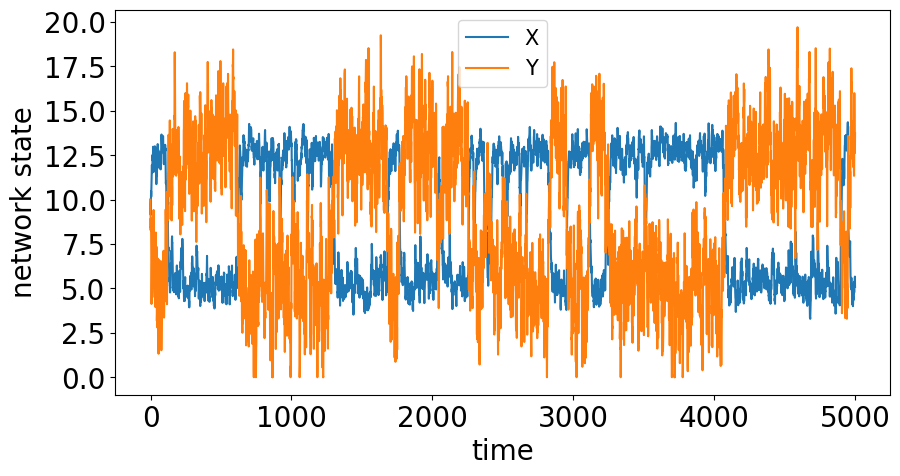

/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])
/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])


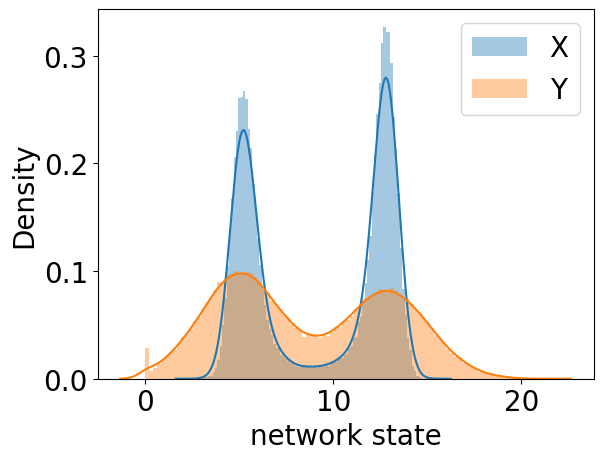

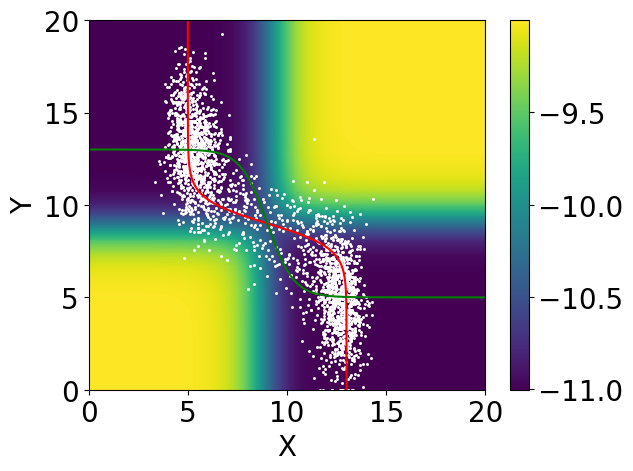

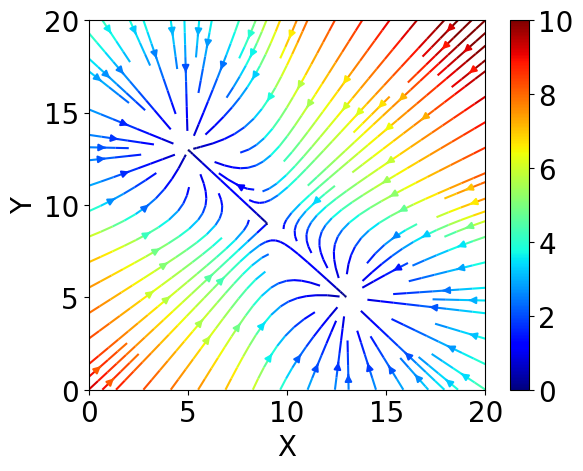

In [6]:

if __name__ == '__main__':
    dim = 2
    varargin = {
        'step': 100000,  # how many steps to run the brain circuit before executing the next movement
        'tau': np.ones(dim),  # decay time constant
        'weights_in': np.ones(dim) * 1.,  # input weights
        'rs': np.ones(dim) * .5,  #

        'w': np.ones(dim) * 4,  # weight of mutual inhibition
        'k': 9 * np.ones(2),  # sigmoid center
        'n': 1.5 * np.ones(2),  # sigmoid slope
        'bi': np.ones(2) * 6.5,  # baseline production
        'dt': 0.4,  # size of timesteps
        'nsf': 0.5,  # noise level
    }

    net = Lyapunov_Worm_multi_D(varargin=varargin, dim=dim)
    choice = net.decide_simulation(0.,0.,0,2, save_history=True, init=False)

    
    net.plot_neural_record()
    net.plot_distribution()
    net.plot_energy()
    net.plot_speed_2D()



100%|██████████| 100000/100000 [00:01<00:00, 72671.25it/s]


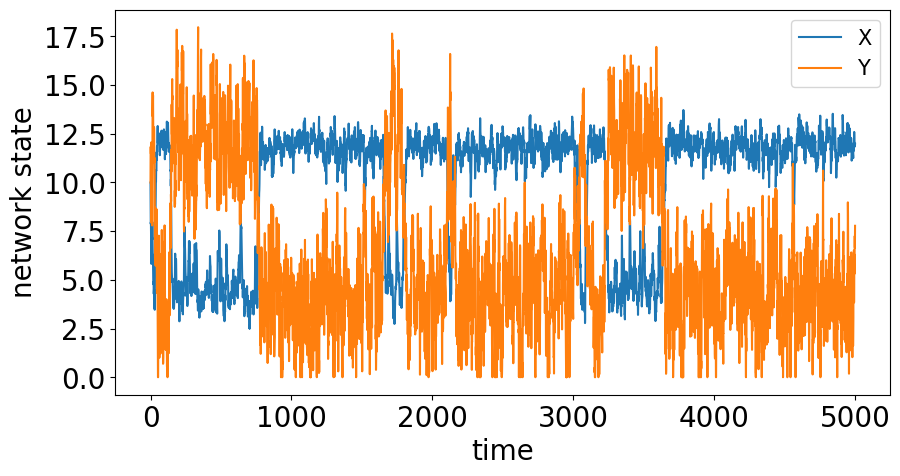

/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])
/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])


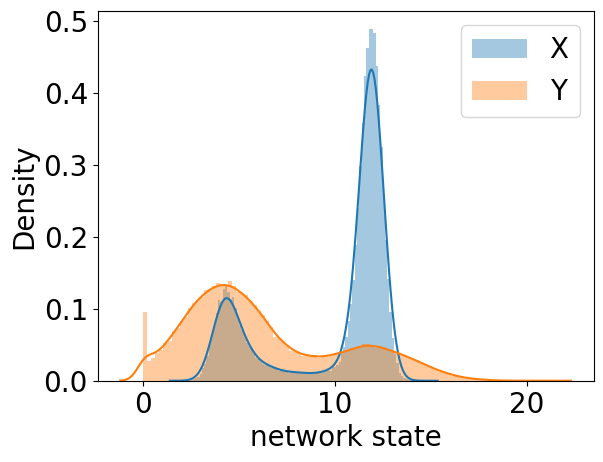

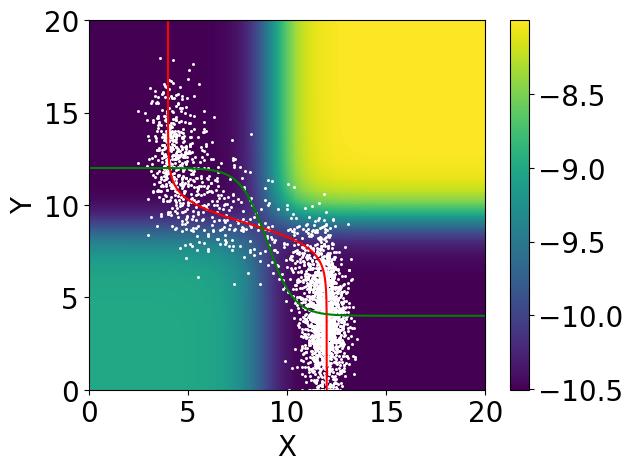

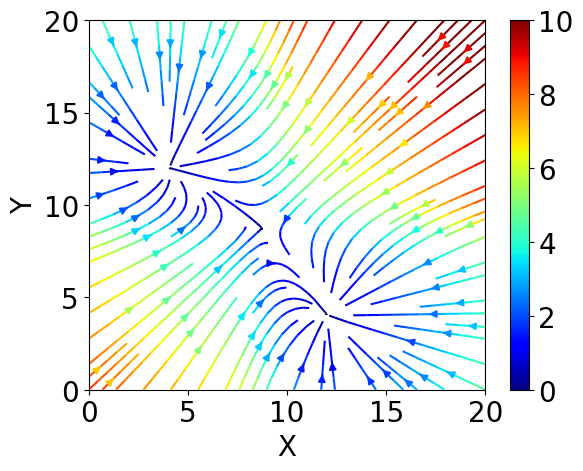

In [7]:
    dim = 2
    varargin = {
        'step': 100000,  # how many steps to run the brain circuit before executing the next movement
        'tau': np.ones(dim),  # decay time constant
        'weights_in': np.ones(dim) * 1.,  # input weights
        'rs': np.ones(dim) * .5,  #

        'w': np.ones(dim) * 4,  # weight of mutual inhibition
        'k': 9 * np.ones(2),  # sigmoid center
        'n': 1.5 * np.ones(2),  # sigmoid slope
        'bi': np.ones(2) * 6.,  # baseline production
        'dt': 0.4,  # size of timesteps
        'nsf': 0.5,  # noise level
    }

    net = Lyapunov_Worm_multi_D(varargin=varargin, dim=dim)

    choice = net.decide_simulation(0.,0.,0,2, save_history=True, init=False)

    net.plot_neural_record()
    net.plot_distribution()
    net.plot_energy()
    net.plot_speed_2D()

100%|██████████| 100000/100000 [00:01<00:00, 73780.36it/s]


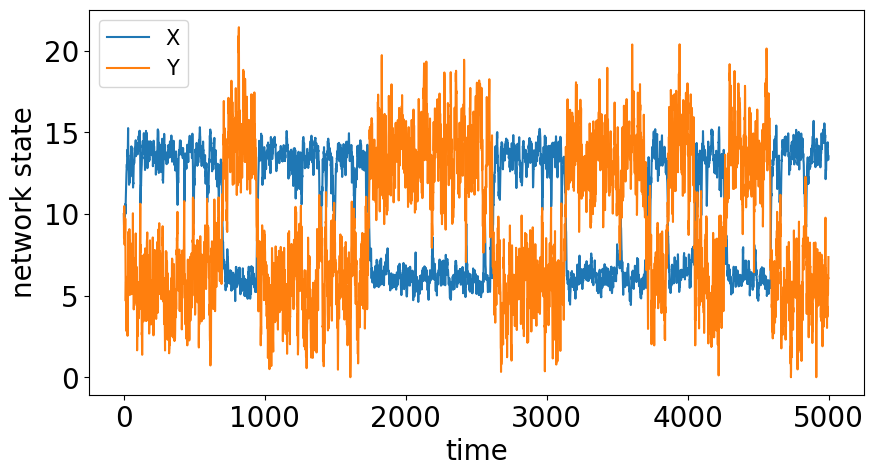

/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])
/tmp/ipykernel_6004/858422867.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neural_history_copy[:, dim], bins=100, label=labels[dim])


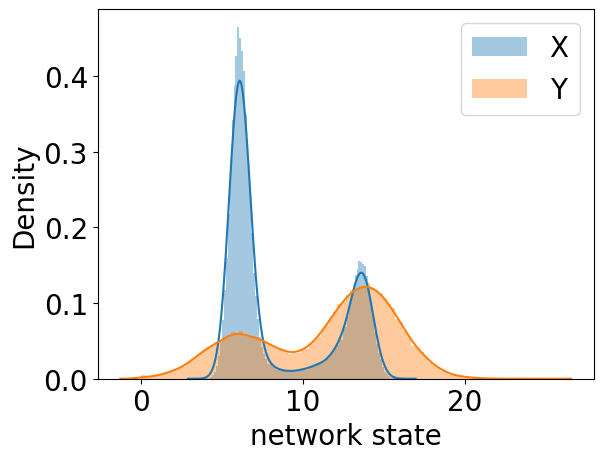

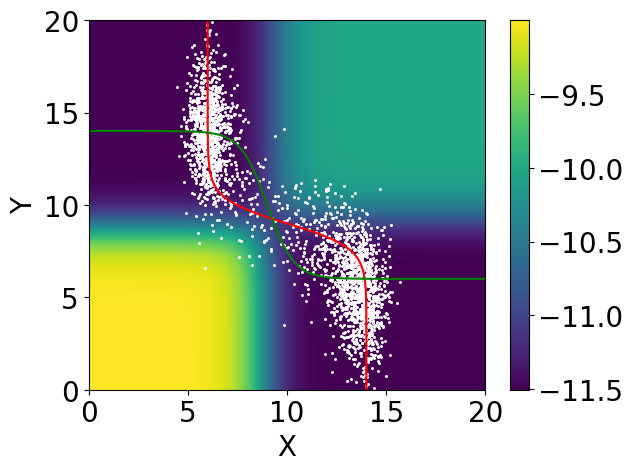

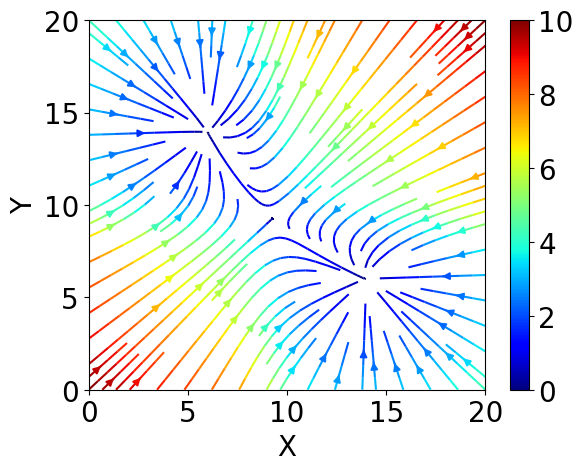

In [8]:
    dim = 2
    varargin = {
        'step': 100000,  # how many steps to run the brain circuit before executing the next movement
        'tau': np.ones(dim),  # decay time constant
        'weights_in': np.ones(dim) * 1.,  # input weights
        'rs': np.ones(dim) * .5,  #

        'w': np.ones(dim) * 4,  # weight of mutual inhibition
        'k': 9 * np.ones(2),  # sigmoid center
        'n': 1.5 * np.ones(2),  # sigmoid slope
        'bi': np.ones(2) * 7.,  # baseline production
        'dt': 0.4,  # size of timesteps
        'nsf': 0.5,  # noise level
    }

    net = Lyapunov_Worm_multi_D(varargin=varargin, dim=dim)

    choice = net.decide_simulation(0.,0.,0,2, save_history=True, init=False)

    net.plot_neural_record()
    net.plot_distribution()
    net.plot_energy()
    net.plot_speed_2D()